In [ ]:
from pathlib import Path
import numpy as np
import tensorflow as tf
import pandas as pd
import warnings
import random
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, recall_score, precision_score

import matplotlib.pyplot as plt

warnings.filterwarnings("ignore", category=FutureWarning)

SEED = 77

In [58]:
datasets = Path('datasets')

data_labels = {}

for i, dir in enumerate(datasets.iterdir()):
    data_labels[dir.name] = i

data_labels

{'Fridges and freezers': 0,
 'Televisions (LCD or LED)': 1,
 'Microwave ovens': 2,
 'Hi-Fi systems (with CD players)': 3,
 'Computers stations (with monitors)': 4,
 'Coffee machines': 5,
 'Laptops (via chargers)': 6,
 'Mobile phones (via chargers)': 7,
 'Lamps (compact fluorescent)': 8,
 'Printers': 9}

In [59]:
colnames = ['phAngle', 'freq', 'reacPower', 'power', 'rmsVolt', 'rmsCur']

data = []
labels = []

for dir in datasets.iterdir():
    label = datasets / dir.name

    for file in label.iterdir():
        
        with open(file, 'r') as f:
            file_content = f.readlines()
        
        file_content = [line[1:-2] for line in file_content if line[0] != '#']
        columns = np.array([list(map(float, row.split(' '))) for row in file_content])
        padded = tf.keras.preprocessing.sequence.pad_sequences(columns, maxlen=360, dtype='float32', padding='pre').T

        data.append(padded)
        labels.append(data_labels[file.parent.name])

data, labels = np.array(data), np.array(labels)

data.shape, labels.shape

((200, 360, 6), (200,))

In [60]:
from sklearn.base import BaseEstimator, TransformerMixin


class Reshape3DTo2D(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.reshape(-1, 6)
    

class Reshape2DTo3D(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.reshape(-1, 360, 6)

In [61]:
from sklearn.discriminant_analysis import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler


preprocess = Pipeline([
    ('to2D', Reshape3DTo2D()),
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler()),
    ('to3D', Reshape2DTo3D())
])

preprocess

Pipeline(steps=[('to2D', Reshape3DTo2D()), ('imputer', SimpleImputer()),
                ('scaler', MinMaxScaler()), ('to3D', Reshape2DTo3D())])

In [82]:
from sklearn.model_selection import train_test_split


X_train, X_validate, Y_train, Y_validate = train_test_split(data, labels, test_size=0.3, stratify=labels, random_state=SEED)
X_validate, X_test, Y_validate, Y_test = train_test_split(X_validate, Y_validate, test_size=0.33, stratify=Y_validate, random_state=SEED)

X_train.shape

(140, 360, 6)

In [83]:
np.random.seed(SEED)

# Augmentation new data with noise
X_train_aug = []
Y_train_aug = []

for i, arr in enumerate(X_train):
    for _ in range(2):
        X_train_aug.append(arr + np.random.normal(0, 0.001, size=arr.shape))
        Y_train_aug.append(Y_train[i])

X_train_aug = np.array(X_train_aug)
Y_train_aug = np.array(Y_train_aug)

X_train = np.concatenate([X_train, X_train_aug], axis=0)
Y_train = np.concatenate([Y_train, Y_train_aug], axis=0)

X_train.shape

(420, 360, 6)

In [86]:
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

def make_model():
    return tf.keras.Sequential([
        tf.keras.layers.Input(shape=(360, 6)),
        tf.keras.layers.GRU(units=256, return_sequences=True),
        tf.keras.layers.GlobalMaxPooling1D(),
        tf.keras.layers.Dense(units=10, activation='softmax'),
    ])

model = make_model()
model.load_weights('started.weights.h5')

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Nadam(),
              metrics=['accuracy']
)

mc1 = tf.keras.callbacks.ModelCheckpoint('best_model_1.keras', monitor='val_accuracy', mode='max', save_best_only=True)
mc2 = tf.keras.callbacks.ModelCheckpoint('best_model_2.keras', monitor='val_loss', mode='min', save_best_only=True)

preprocess.fit(X_train)
history = model.fit(
    preprocess.transform(X_train),
    tf.keras.utils.to_categorical(Y_train),
    validation_data=(preprocess.transform(X_validate), tf.keras.utils.to_categorical(Y_validate)),
    batch_size=8,
    epochs=100,
    callbacks=[mc1, mc2],
)

Epoch 1/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.1804 - loss: 2.2453 - val_accuracy: 0.2250 - val_loss: 2.0509
Epoch 2/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.3097 - loss: 1.8153 - val_accuracy: 0.3250 - val_loss: 1.6590
Epoch 3/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.4401 - loss: 1.4677 - val_accuracy: 0.3750 - val_loss: 1.5845
Epoch 4/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.4808 - loss: 1.3099 - val_accuracy: 0.4500 - val_loss: 1.5772
Epoch 5/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.5494 - loss: 1.2122 - val_accuracy: 0.4750 - val_loss: 1.4784
Epoch 6/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.5827 - loss: 1.0980 - val_accuracy: 0.4750 - val_loss: 1.4145
Epoch 7/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.6599 - loss: 0.9725 - val_accuracy: 0.5250 - val_loss: 1.3295
Epoch 8/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.6531 - loss: 0.9039 - val_accuracy: 0.

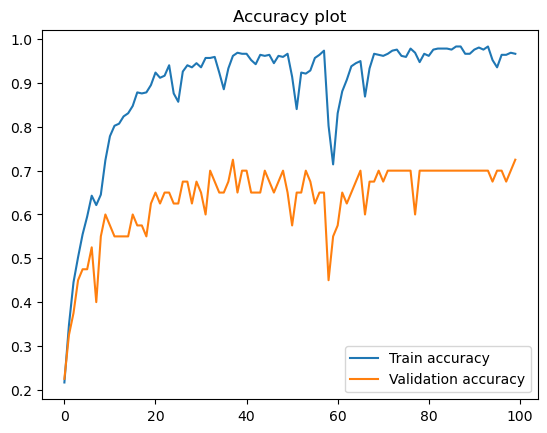

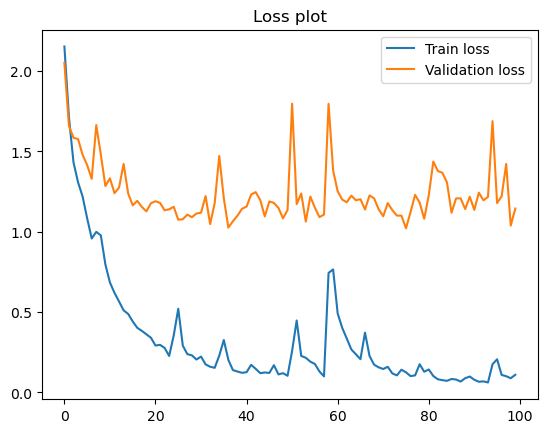

In [87]:
plt.plot(history.epoch, history.history['accuracy'], label='Train accuracy')
plt.plot(history.epoch, history.history['val_accuracy'], label='Validation accuracy')
plt.legend()
plt.title('Accuracy plot')
plt.show()

plt.plot(history.epoch, history.history['loss'], label='Train loss')
plt.plot(history.epoch, history.history['val_loss'], label='Validation loss')
plt.legend()
plt.title('Loss plot')
plt.show()

Test accuracy: 0.7
Test recall: 0.7
Test precision: 0.7166666666666666
Test f1: 0.6966666666666667


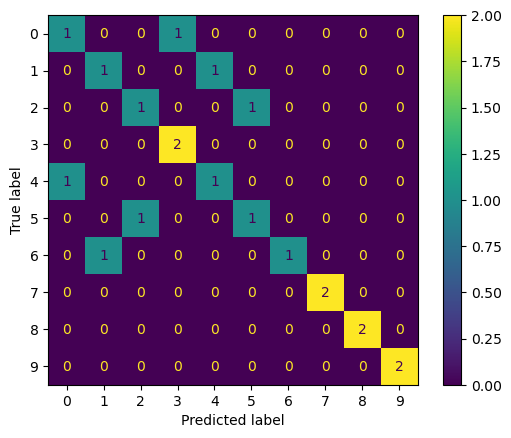

In [89]:
model = tf.keras.models.load_model('best_model_2.keras')

preds = np.argmax(model.predict(preprocess.transform(X_test), verbose=0), axis=1)

results = pd.DataFrame({
    'preds': preds,
    'true': Y_test
})

print(f'Test accuracy: {accuracy_score(results['true'], results['preds'])}')
print(f'Test recall: {recall_score(results['true'], results['preds'], average='weighted')}')
print(f'Test precision: {precision_score(results['true'], results['preds'], average='weighted')}')
print(f'Test f1: {f1_score(results['true'], results['preds'], average='weighted')}')

cm = confusion_matrix(results['true'], results['preds'])
ConfusionMatrixDisplay(cm).plot()

# Crossvalidation

In [99]:
X_train, X_test, Y_train, Y_test = train_test_split(data, labels, test_size=0.1, stratify=labels, random_state=SEED)

X_train.shape

(180, 360, 6)

In [104]:
from sklearn.model_selection import StratifiedKFold


random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

accuracies = []


skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

for train_index, val_index in skf.split(X_train, Y_train):
    
    X_train_fold, X_val = X_train[train_index], X_train[val_index]
    Y_train_fold, Y_val = Y_train[train_index], Y_train[val_index]

    X_train_aug = []
    Y_train_aug = []

    for i, arr in enumerate(X_train_fold):
        for _ in range(2):
            X_train_aug.append(arr + np.random.normal(0, 0.001, size=arr.shape))
            Y_train_aug.append(Y_train_fold[i])

    X_train_aug = np.array(X_train_aug)
    Y_train_aug = np.array(Y_train_aug)

    X_train_fold = np.concatenate([X_train_fold, X_train_aug], axis=0)
    Y_train_fold = np.concatenate([Y_train_fold, Y_train_aug], axis=0)

    print(X_train_fold.shape)

    model = make_model()
    model.load_weights('started.weights.h5')

    model.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Nadam(),
                metrics=['accuracy']
    )

    mc = tf.keras.callbacks.ModelCheckpoint('best_model_folds.keras', monitor='val_loss', mode='min', save_best_only=True)

    preprocess.fit(X_train)
    history = model.fit(
        preprocess.transform(X_train_fold),
        tf.keras.utils.to_categorical(Y_train_fold),
        validation_data=(preprocess.transform(X_validate), tf.keras.utils.to_categorical(Y_validate)),
        batch_size=8,
        epochs=100,
        verbose=0,
        callbacks=[mc],
    )

    model = tf.keras.models.load_model('best_model_folds.keras')

    preds = np.argmax(model.predict(preprocess.transform(X_test), verbose=0), axis=1)

    acc = accuracy_score(Y_test, preds)
    accuracies.append(acc)

    print(f'Test accuracy: {acc}')
    print(f'Test recall: {recall_score(results['true'], results['preds'], average='weighted')}')
    print(f'Test precision: {precision_score(results['true'], results['preds'], average='weighted')}')
    print(f'Test f1: {f1_score(results['true'], results['preds'], average='weighted')}')

    cm = confusion_matrix(results['true'], results['preds'])
    print(cm)
    print()
    

print(f'Mean test accuracy: {np.mean(accuracies)}')

(432, 360, 6)
Test accuracy: 0.65
Test recall: 0.7
Test precision: 0.7166666666666666
Test f1: 0.6966666666666667
[[1 0 0 1 0 0 0 0 0 0]
 [0 1 0 0 1 0 0 0 0 0]
 [0 0 1 0 0 1 0 0 0 0]
 [0 0 0 2 0 0 0 0 0 0]
 [1 0 0 0 1 0 0 0 0 0]
 [0 0 1 0 0 1 0 0 0 0]
 [0 1 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 2 0 0]
 [0 0 0 0 0 0 0 0 2 0]
 [0 0 0 0 0 0 0 0 0 2]]

(432, 360, 6)
Test accuracy: 0.65
Test recall: 0.7
Test precision: 0.7166666666666666
Test f1: 0.6966666666666667
[[1 0 0 1 0 0 0 0 0 0]
 [0 1 0 0 1 0 0 0 0 0]
 [0 0 1 0 0 1 0 0 0 0]
 [0 0 0 2 0 0 0 0 0 0]
 [1 0 0 0 1 0 0 0 0 0]
 [0 0 1 0 0 1 0 0 0 0]
 [0 1 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 2 0 0]
 [0 0 0 0 0 0 0 0 2 0]
 [0 0 0 0 0 0 0 0 0 2]]

(432, 360, 6)
Test accuracy: 0.65
Test recall: 0.7
Test precision: 0.7166666666666666
Test f1: 0.6966666666666667
[[1 0 0 1 0 0 0 0 0 0]
 [0 1 0 0 1 0 0 0 0 0]
 [0 0 1 0 0 1 0 0 0 0]
 [0 0 0 2 0 0 0 0 0 0]
 [1 0 0 0 1 0 0 0 0 0]
 [0 0 1 0 0 1 0 0 0 0]
 [0 1 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 2 0 0]
 [0 0 0 0 